# AODAPI viability and inflection points

In [1]:
import numpy as np
import scipy.optimize as optim
import math
import os,sys
import pandas as pd
import copy
import scipy.stats as st
from scipy.stats import t
import matplotlib.pyplot as plt
from matplotlib import rcParams

**Read viability and T2 inflection points**

In [2]:
cwd = os.getcwd()
data_directory = './data/'
os.chdir(data_directory)

aodapi_T2 = pd.read_csv('AODAPI-T2paired-Day1.csv')

column_names = list(aodapi_T2)

aodapis, t2s = {}, {}

for c in column_names:
    if 'T2' in c:
        t2s[c] = [round(x,2) for x in aodapi_T2[c] if math.isnan(x) == False]
        print(c,'\t',t2s[c])
        
    if 'AODAPI' in c:
        aodapis[c] = [round(x,2) for x in aodapi_T2[c] if math.isnan(x) == False]
        print(c,'\t',aodapis[c])

Study1_AODAPI 	 [91.05, 90.42, 85.12, 78.8, 77.35, 65.49, 62.27]
Study1_T2 	 [74.93, 122.59, 104.11, 164.45, 150.77, 193.53, 443.6]
Study3_AODAPI 	 [96.18, 94.71, 89.54, 83.76, 71.59, 68.47]
Study3_T2 	 [102.31, 80.83, 85.02, 126.79, 147.27, 178.04]
Study4_AODAPI 	 [97.09, 91.58, 77.33, 61.27]
Study4_T2 	 [93.02, 113.0, 193.43, 212.21]
Study5_AODAPI 	 [91.72, 94.21, 63.61, 64.17]
Study5_T2 	 [71.64, 72.14, 159.66, 190.13]


**Fit $\log[\mathrm{AODAPI}]$-vs-T2.**

In [3]:
x, y = [], []

for c in aodapis.keys():
    x += aodapis[c]

for c in t2s.keys():
    y += t2s[c]
    
dof = len(x) - 2
    
x = np.array(x)/100
y = np.array(y)
    
result = st.linregress(np.log(x),np.log(y),alternative='two-sided')
    
print(result)    

LinregressResult(slope=-2.386117710101085, intercept=4.3406484978039686, rvalue=-0.8571336853655246, pvalue=6.957401776983424e-07, stderr=0.3289675081083341, intercept_stderr=0.09084907311224924)


**Reduced $\chi^2$ error:**

In [4]:
residual = np.exp(result.slope*np.log(x) + result.intercept) - y

print(math.sqrt(np.dot(residual,residual)/(x.shape[0]-2)))

54.571758503185855


In [5]:
mean_aodapi = np.linspace(60,100,100)
t2 = np.exp(result.slope*np.log(mean_aodapi/100) + result.intercept)

fitname = r'T2 = ' + str(round(math.exp(result.intercept),2)) + '(AODAPI/100)$^{'+ str(round(result.slope,1)) + '}$'

**Compute upper and lower bounds of the fit using 95% CI of the fit parameters.**

In [6]:
tinv = lambda p, df: abs(t.ppf(p/2,df))
ts = tinv(0.05,dof)
print(ts)

s_err = ts*result.stderr
i_err = ts*result.intercept_stderr

print(s_err,i_err)

2.0930240544082634
0.6885369075894887 0.19014929534463265


In [7]:
s_up, i_up = result.slope + s_err, result.intercept - i_err
s_low, i_low = result.slope - s_err, result.intercept + i_err

t2_up = np.exp(s_up*np.log(mean_aodapi/100) + i_up)
t2_low = np.exp(s_low*np.log(mean_aodapi/100) + i_low)

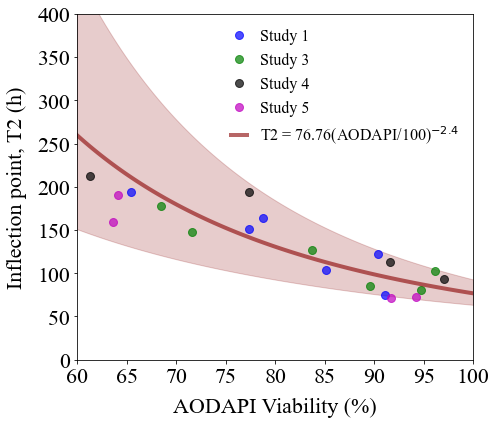

In [8]:
studies = ['Study1','Study3','Study4','Study5']

fig, axs = plt.subplots(figsize=(7,6))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

color_list = {'Study1':'blue','Study3':'green','Study4':'black','Study5':'m'}

for s in studies:
    labelname = s.replace('Study','Study ')
    plt.plot(aodapis[s+'_AODAPI'],t2s[s+'_T2'],marker='o',ms=8,color=color_list[s],alpha=0.7,linewidth=0,label=labelname)

plt.plot(mean_aodapi,t2,linewidth=4,color='#880000',alpha=0.6,label=fitname)

plt.fill_between(mean_aodapi,t2_up,t2_low,alpha=0.2,color='#880000')

plt.xticks(size=22)
plt.yticks(size=22)  
plt.xlabel(r'AODAPI Viability (%)',size=22,labelpad=10)
plt.ylabel(r'Inflection point, T2 (h)',size=22,rotation=90,labelpad=10)
plt.xlim(60,100)
plt.ylim(0,400)
plt.legend(frameon=False,prop={'size': 16,'family':'Times New Roman'},markerscale=1.0,handlelength=1.0,loc='upper right')
plt.tight_layout()